In [ ]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9f456c6411027578d2ff219c8c9c3b34992654e36b773687317e3c3830ed4fca
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign
print(df_bc.sample(10))

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
234        9.567         15.91           60.21      279.6          0.08464   
385       14.600         23.29           93.97      664.7          0.08682   
55        11.520         18.75           73.34      409.0          0.09524   
533       20.470         20.67          134.70     1299.0          0.09156   
165       14.970         19.76           95.50      690.2          0.08421   
358        8.878         15.49           56.74      241.0          0.08293   
212       28.110         18.47          188.50     2499.0          0.11420   
353       15.080         25.74           98.00      716.6          0.10240   
498       18.490         17.52          121.30     1068.0          0.10120   
115       11.930         21.53           76.53      438.6          0.09768   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
234           0.04087         0.01652              0.01667      

# **Exploratory Data Analysis (EDA)**

In [ ]:
# 1. Descriptive Statistics

print(df_bc.describe())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

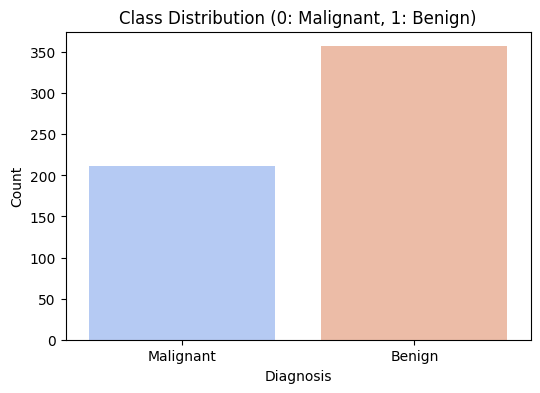

In [ ]:
# 2. Class Distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_bc, palette='coolwarm')
plt.title('Class Distribution (0: Malignant, 1: Benign)')
plt.xticks([0, 1], ['Malignant', 'Benign'])
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


In [ ]:
# 3. Correlation Analysis

corr_matrix = df_bc.corr()
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Top 10 features most correlated with the target (Benign Diagnosis):")
print(target_corr.head(10))
print("\nTop 10 features most negatively correlated with the target (Malignant Diagnosis):")
print(target_corr.tail(10))

Top 10 features most correlated with the target (Benign Diagnosis):
target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
Name: target, dtype: float64

Top 10 features most negatively correlated with the target (Malignant Diagnosis):
worst concavity        -0.659610
mean concavity         -0.696360
mean area              -0.708984
mean radius            -0.730029
worst area             -0.733825
mean perimeter         -0.742636
worst radius           -0.776454
mean concave points    -0.776614
worst perimeter        -0.782914
worst concave points   -0.793566
Name: target, dtype: float64


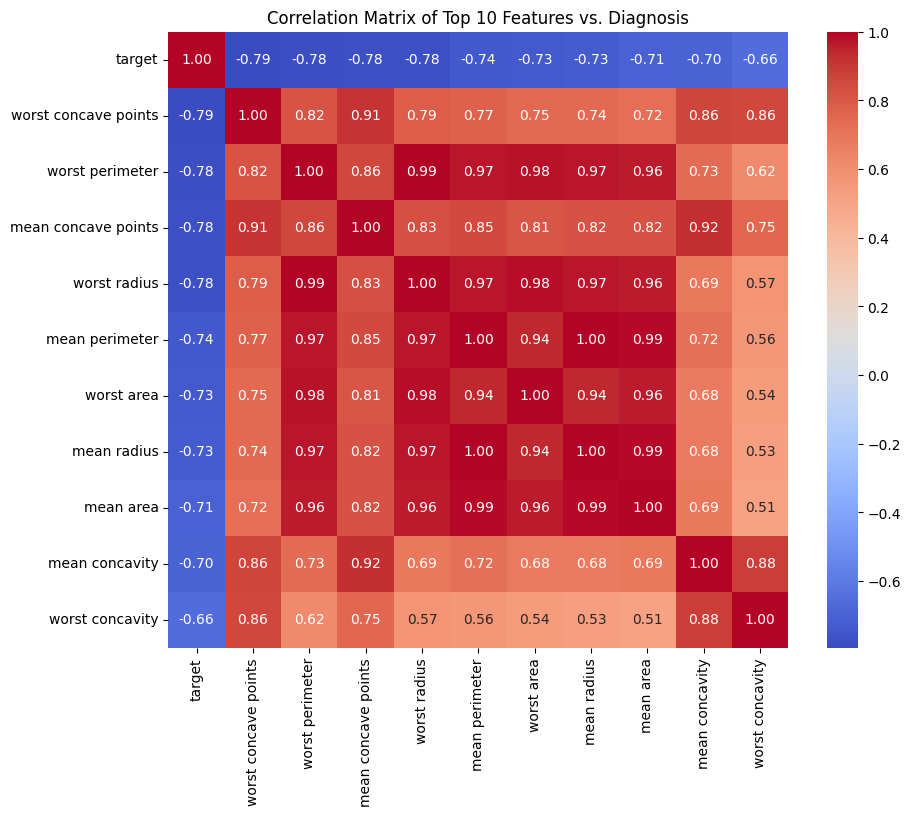

In [ ]:
# Find the 10 features most correlated with the target
top_features = corr_matrix['target'].abs().nlargest(11).index
top_corr_matrix = df_bc[top_features].corr()

# 4. Create the heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, cmap='coolwarm', annot=True, fmt='.2f') # Formatted to 2 decimals
plt.title('Correlation Matrix of Top 10 Features vs. Diagnosis')
plt.show()

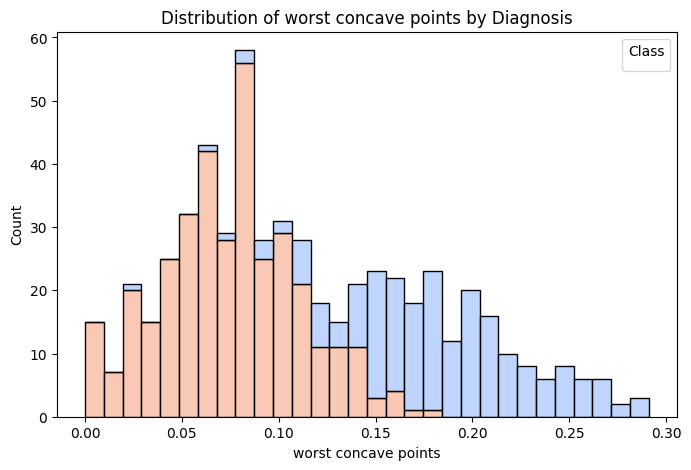

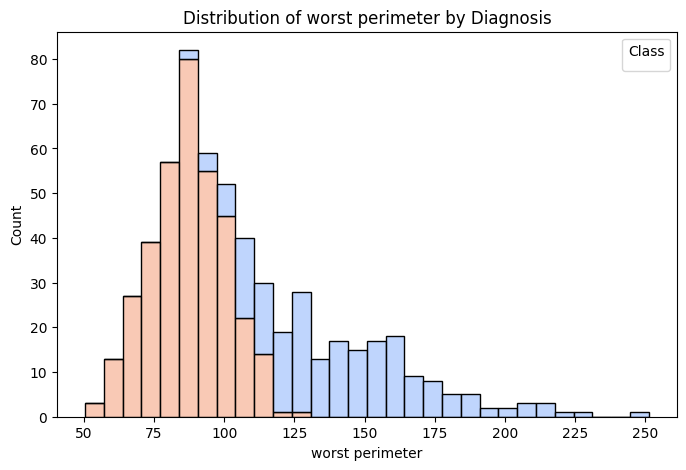

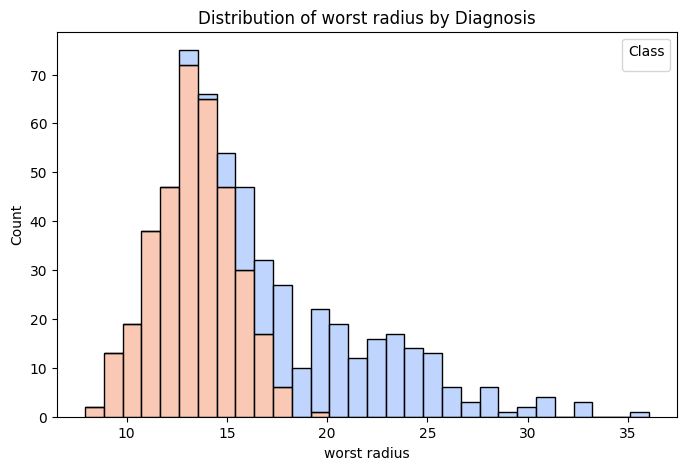

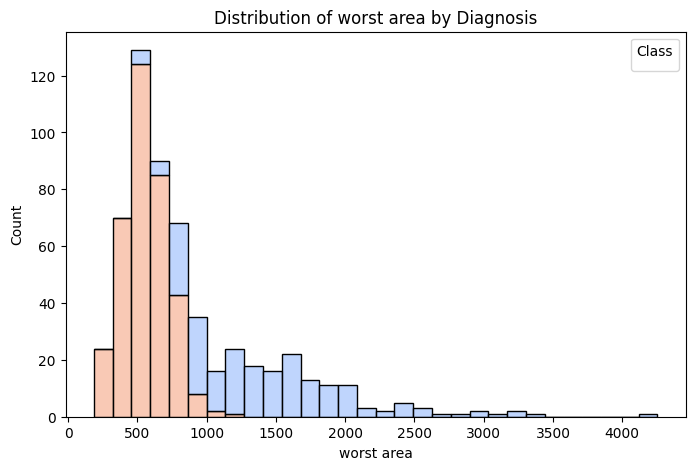

In [ ]:
# 5. Distribution of Key Features by Class

key_features = ['worst concave points', 'worst perimeter', 'worst radius', 'worst area']

for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_bc, x=feature, hue='target', multiple='stack', palette='coolwarm', bins=30)
    plt.title(f'Distribution of {feature} by Diagnosis')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Benign', 'Malignant'], title='Class')
    plt.show()

### **EDA Interpretation**
Summary of Exploratory Data Analysis:
This analysis explores the Wisconsin Breast Cancer dataset, which contains 569 tumor instances described by 30 features computed from digitized images of cell nuclei. The goal is to distinguish between malignant (cancerous) and benign (non-cancerous) tumors.

Class Balance:
The dataset includes 357 benign and 212 malignant cases. While not perfectly balanced, this distribution is suitable for training a reliable predictive model.

Key Predictive Features:
The correlation heatmap and feature distribution plots reveal the most important predictors for malignancy.

Correlation: Features related to the "worst" (largest mean) measurements of a tumor have the strongest relationship with a malignant diagnosis. The most significant are worst concave points, worst perimeter, worst radius, and worst area. These features are highly negatively correlated with the "benign" target, meaning higher values strongly indicate malignancy.

Distribution: The histograms show a clear visual separation between the two classes. For key features like worst area, malignant tumors (represented by the blue bars) consistently have higher values than benign tumors (the peach bars). This distinct separation is why these features are so effective for classification.

Feature Relationships:
The heatmap also shows that many features related to size (e.g., mean radius, mean perimeter, and mean area) are highly correlated with each other. This is expected, as they all measure a similar underlying property of the tumor.

In [ ]:
# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)

print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")

Prediction for Patient X: Benign → No Biopsy


# **LIME Analysis**

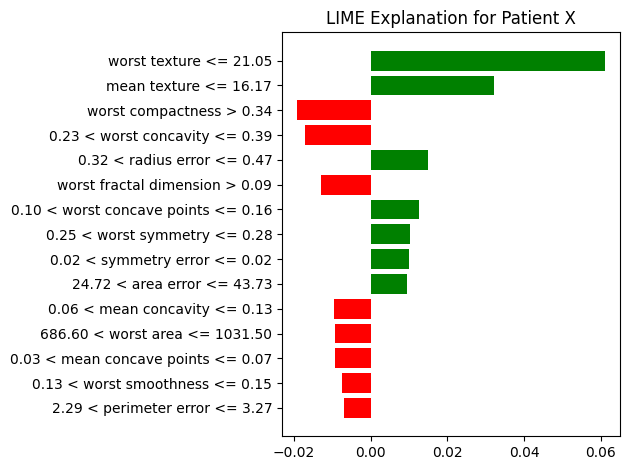

In [ ]:
# Create a LIME explainer object
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=data.feature_names,
    class_names=data.target_names,
    mode='classification'
)

# Explain the focus instance
explanation_lime = explainer_lime.explain_instance(
    data_row=focus_instance_bc.iloc[0].values,
    predict_fn=model_bc.predict_proba,
    num_features=15
)

# Visualize the LIME explanation
fig = explanation_lime.as_pyplot_figure()
plt.title('LIME Explanation for Patient X')
plt.tight_layout()
plt.show()

### **LIME Interpretation**
This LIME plot explains the model's prediction for Patient X. The green bars represent features that support a "Benign" classification, while the red bars support a "Malignant" one. The length of each bar shows the feature's influence on the final decision.

Based on the overwhelming weight of the green bars, the model's prediction for this patient is Benign.

Evidence for a Benign Prediction (Green Bars): The model's decision is most strongly influenced by two key features: worst texture <= 21.05 and mean texture <= 16.17. These relatively low texture values are the primary indicators that the model used to classify the tumor as benign. Several other features, such as a low concave points error and a specific range for worst symmetry, also add to this conclusion, though with less impact.

Evidence Against a Benign Prediction (Red Bars): A number of features provide conflicting evidence. The strongest factors pushing towards a malignant classification are worst compactness > 0.34 and a worst concavity value between 0.23 and 0.39. These suggest some characteristics that the model associates with malignancy, but their influence is not strong enough to change the outcome.

In conclusion, despite some concerning features related to the tumor's compactness and concavity, the model's Benign prediction is confidently made based on the strong evidence provided by the low texture values.

# **SHAP Analysis**


## 1. Global Feature Importance Analysis
Generating Global Feature Importance Summary Plot (Violin)...


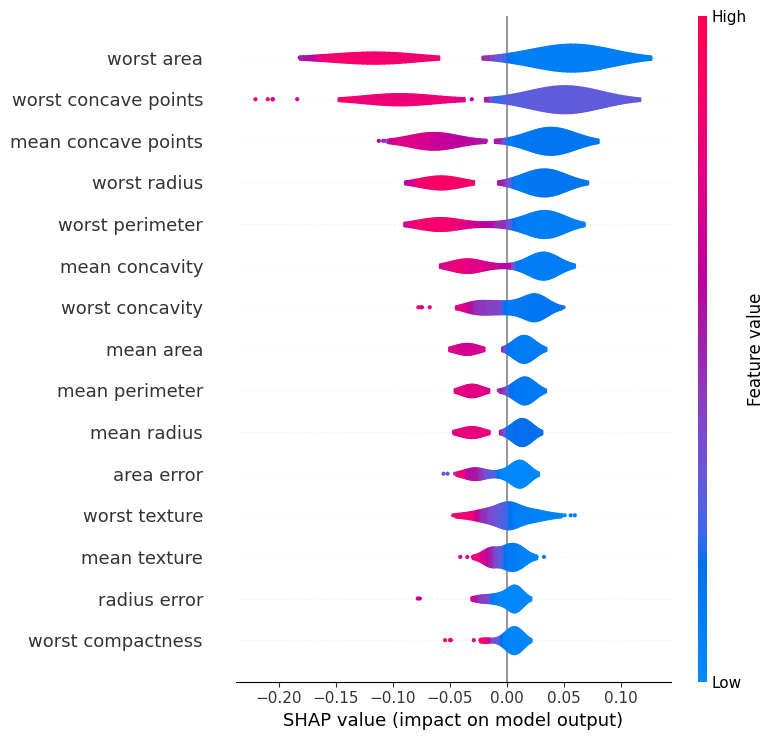


## 2. Local Explanation for Patient X
Generating Local Force Plot for Patient X...



## 3. Feature Interaction Analysis: Worst Texture
Generating Feature Dependence Plot for 'worst texture'...


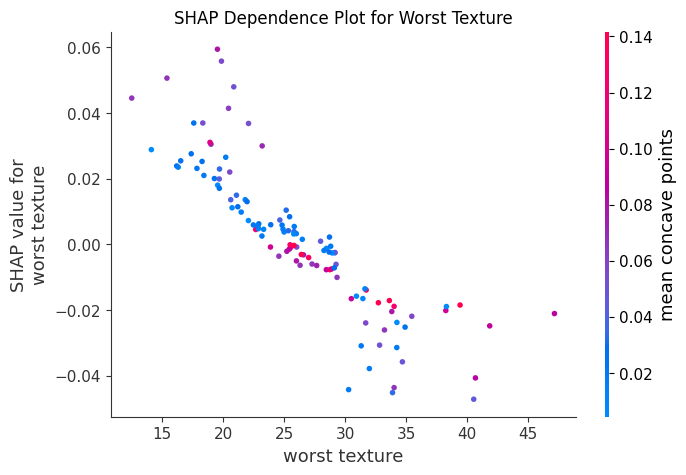

In [ ]:
# Initialize Javascript for interactive plots
shap.initjs()

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(model_bc)

# 1. Global Feature Importance (across the entire test set)
print("\n## 1. Global Feature Importance Analysis")
shap_values = explainer(X_test)

# Create a SHAP Explanation object for the "Benign" class (class 1)
shap_values_benign = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# Generate and display the Summary Plot (Violin style)
print("Generating Global Feature Importance Summary Plot (Violin)...")
shap.summary_plot(shap_values_benign, plot_type="violin", max_display=15)
plt.show()

# 2. Local Explanation for Patient X
print("\n## 2. Local Explanation for Patient X")
ex = explainer(focus_instance_bc)

# Generate and display the interactive Force Plot
print("Generating Local Force Plot for Patient X...")
display(shap.force_plot(
    base_value=ex.base_values[0, 1],
    shap_values=ex.values[0, :, 1],
    features=focus_instance_bc
))

# 3. Feature Interaction Analysis: Worst Texture
print("\n## 3. Feature Interaction Analysis: Worst Texture")

# Generate and display the Dependence Plot
print("Generating Feature Dependence Plot for 'worst texture'...")
shap.dependence_plot(
    "worst texture",
    shap_values.values[:, :, 1],
    X_test,
    interaction_index="auto",
    show=False
)
plt.title("SHAP Dependence Plot for Worst Texture")
plt.show()

### **SHAP Interpretation**
This analysis uses several visualizations to explain the model's predictions for breast cancer classification.

1. Global Feature Importance:
The SHAP violin plot shows the model's most important features across all test data. worst concave points and worst area have the greatest impact. The plot reveals that high values for these features (shown in red) consistently push the model's prediction toward "Malignant" (indicated by negative SHAP values).

2. Local Explanation for Patient X:
The interactive force plot explains the "Benign" prediction for this specific patient. The model starts with the dataset's average prediction (a 63% chance of being benign) and adjusts it based on the patient's features. For this patient, low values for worst texture and mean texture were the strongest factors pushing the prediction to a final, confident "Benign" probability of 85%.

3. Feature Interaction Analysis:
The dependence plot for worst texture shows that as its value increases, the likelihood of a benign diagnosis decreases. The plot also reveals an interaction with worst concave points (shown in color); a high worst texture is an even stronger indicator of malignancy when worst concave points is also high.